# 1. Tensorflow basics

In [7]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt


#### In Tensorflow the computation graph has to be constructed before the actual computation can take place

In [5]:
# Hello world! in Tensorflow
hello = tf.constant('Hello world!')

In [6]:
print(hello)

Tensor("Const:0", shape=(), dtype=string)


In [7]:
# start a Tensorflow session
session = tf.Session()

In [8]:
# run the graph we just built
# .decode() interprets the bytestring coming from tensorflow
print(session.run(hello).decode())

Hello world!


In [9]:
# Basic constant operations
# The value returned by the constructor represents the output
# of the Constant op
const1 = tf.constant(5)
const2 = tf.constant(10)

# Launch the default graph.
with tf.Session() as sess:
    print("Constant 1: {}".format(sess.run(const1)), "Constant 2: {}".format(sess.run(const2)))
    print("Addition result of the two constants: {}".format(sess.run(const1+const2)))
    print("Multiplication result of the two constants: {}".format(sess.run(const1*const2)))

Constant 1: 5 Constant 2: 10
Addition result of the two constants: 15
Multiplication result of the two constants: 50


In [11]:
# replace constants with variables
var1 = tf.placeholder(tf.int16)
var2 = tf.placeholder(tf.int16)

# define the addition and multiplication operations
# these operations are defined in the graph, but not yet performed
add = tf.add(var1, var2)
multiply = tf.multiply(var1, var2)

In [12]:
# To run the matmul op we call the session 'run()' method, passing 'add' or 'multiply'
# which represents the output of the op defined above.
#
# All inputs needed by the op are run automatically by the session.  They
# typically are run in parallel.
#
# The call 'run(multiply)' thus causes the execution of threes ops in the
# graph: the two variables and the multiply op.
#
# The output of the op is returned in 'addition_result' as a numpy `ndarray` object.
with tf.Session() as sess:
    print("Addition result of the two variables: {}".format(sess.run(add,
                                                                     feed_dict={var1:3, var2:5})))
    print("Multiplication result of the two variables: {}".format(sess.run(multiply, feed_dict={var1:3, var2:5})))



Addition result of the two variables: 8
Multiplication result of the two variables: 15


In [14]:
# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

In [15]:
# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
matrix_product = tf.matmul(matrix1, matrix2)

In [17]:
# run the graph and get the result
with tf.Session() as sess:
    result = sess.run(matrix_product)
    print("Multiplication result of the two matrices: {}".format(result))

Multiplication result of the two matrices: [[ 12.]]


# Implement Q-learning with a table

In [19]:
env = gym.make('FrozenLake-v0')

In [20]:
print(env.action_space.n)

4


In [21]:
# Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
learn_rate = .8
gamma = .95
num_episodes = 2000
reward_list = []
for i in range(num_episodes):
    # Reset environment and get first new observation
    state = env.reset()
    reward_epoch = 0
    done = False
    ep_length = 0
    # The Q-Table learning algorithm
    while ep_length < 99:
        ep_length += 1
        # Choose an action by greedily (with noise) picking from Q table
        action = np.argmax(Q[state,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        # Get new state and reward from environment
        new_state, reward, done, _ = env.step(action)
        # Update Q-Table with new knowledge
        Q[state,action] = Q[state,action] + learn_rate*(reward +
                                                        gamma*np.max(Q[new_state,:]) - Q[state,action])
        reward_epoch += reward
        state = new_state
        if done == True:
            break
    reward_list.append(reward_epoch)

In [22]:
print("Score over time: " +  str(sum(reward_list)/num_episodes))
print("Final Q-Table Values", Q)

Score over time: 0.4925
Final Q-Table Values [[  2.40388148e-01   7.74923743e-03   9.41435197e-03   6.89341629e-03]
 [  2.01615981e-03   9.39970571e-04   5.78901215e-05   1.03036469e-01]
 [  3.02890089e-03   1.75647061e-03   5.35804647e-03   1.04354748e-01]
 [  5.02984857e-04   9.71420688e-04   7.74232329e-05   7.25445107e-02]
 [  2.89158126e-01   7.70018218e-03   3.31325970e-04   3.99136750e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  8.39996084e-04   2.70678769e-05   2.83235652e-02   1.61050105e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.13172893e-03   1.68866558e-03   3.92915903e-01]
 [  0.00000000e+00   5.17035433e-01   2.94274665e-03   9.67671962e-04]
 [  4.69967478e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   8.04387954e

In [23]:
print(len(reward_list))

2000


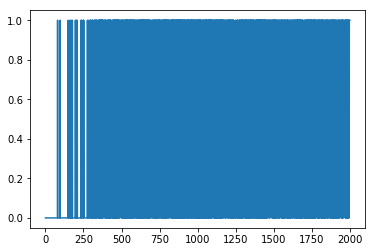

In [24]:
plt.plot(reward_list)

# Implement Q-learning with a neural network

In [25]:
env = gym.make('FrozenLake-v0')

In [26]:
tf.reset_default_graph()

In [28]:
# These lines establish the feed-forward part of the network used to choose actions
inputs = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs, W)
predict = tf.argmax(Qout, 1)

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [29]:
init = tf.initialize_all_variables()

# Set learning parameters
gamma = .99
epsilon = 0.1
num_episodes = 2000
# create lists to contain total rewards and steps per episode
step_list = []
reward_list = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        state = env.reset()
        reward_episode = 0
        done = False
        ep_length = 0
        while ep_length < 99:
            ep_length+=1
            action, allQ = sess.run([predict, Qout],
                                    feed_dict={inputs:np.identity(16)[state:state+1]})
            if np.random.rand(1) < epsilon:
                action[0] = env.action_space.sample()
            # Get new state and reward from environment
            new_state, reward, done,_ = env.step(action[0])
            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs:np.identity(16)[new_state:new_state+1]})
            # Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, action[0]] = reward + gamma*maxQ1
            # Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs:np.identity(16)[state:state+1],
                                                       nextQ:targetQ})
            reward_episode += reward
            state = new_state
            if done == True:
                # Reduce chance of random action as we train the model.
                epsilon = 1./((i/50) + 10)
                break
        step_list.append(ep_length)
        reward_list.append(reward_episode)
print("Percent of succesful episodes: {}%".format(str(sum(reward_list)/num_episodes)))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Percent of succesful episodes: 0.3955%


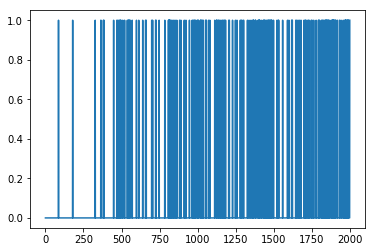

In [39]:
plt.plot(reward_list)

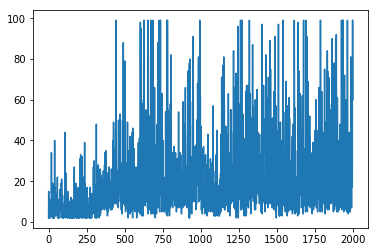

In [40]:
plt.plot(step_list)

# Solving CartPole with DQN 

In [8]:
class ExperienceReplay: 
    """
    Store experiences and use them for training
    """
    def __init__(self, size):
        self.experiences = deque()
        self.size = size
        self.num_experiences = 0
        
    def add_experience(self, experience):
        if self.size > self.num_experiences:
            self.experiences.append(experience)
            self.num_experiences += 1
        else:
            self.experiences.popleft()
            self.experiences.append(experience)
            
    def sample_batch(batch_size):
        if batch_size >= self.size:
            return(random.sample(self.buffer, batch_size))
        else:
            return(random.sample(self.buffer, self.num_experiences))
        
    def num_experiences():
        return(self.length)
    
    def reset():
        self.experiences = deque()
        self.num_experiences = 0
    

In [10]:
class Brain:
    """
    Create a neural network that will act as the brain of an agent
    """
    def __init__(self, inp_shape, output_size):
        self.inp_shape = inp_shape
        self.output_size = output_size
        self.create_model()
        
    def weight_variable(self, shape, name):
        return(tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name))

    def bias_variable(self, shape, name):
        init = tf.constant(0.01, shape = [shape])
        return(tf.Variable(init, name=name))

    def create_model(self):
        self.inp = tf.placeholder(tf.float32, [None, self.inp_shape], name = "input")
        self.W1 = self.weight_variable([self.inp_shape, 20], "W1")
        self.b1 = self.bias_variable(20, "b1")
        self.hidden1 = tf.nn.relu(tf.matmul(self.inp, self.W1) + self.b1)
        #self.W2 = self.weight_variable([20, 20], "W2")
        #self.b2 = self.bias_variable(20, "b2")
        #self.hidden2 = tf.nn.relu(tf.matmul(self.hidden1, self.W2) + self.b2)
        self.Wout = self.weight_variable([20, self.output_size], "Wout")
        self.bout = self.bias_variable(self.output_size, "bout")
        self.Q = tf.matmul(self.hidden1, self.Wout) + self.bout

        self.net_params = [self.W1, self.b1, self.Wout, self.bout]
        self.predict = tf.argmax(self.Q, 1)
        self.nextQ = tf.placeholder(tf.float32, [1, self.output_size])
        self.loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        self.trainer = tf.train.AdamOptimizer(0.0005)
        self.updateModel = self.trainer.minimize(self.loss)


In [11]:
class Agent:
    """
    Build the agent that learns to solve the problem
    """
    def __init__(self, problem="CartPole-v0", buffer_size=10000, batch_size=10, gamma=0.9,
                 exploration_decay=0.99, exploration_prob = 0.5, learning_rate=.1):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.exploration_decay = exploration_decay
        self.exploration_prob = exploration_prob
        self.learning_rate = learning_rate
        self.game = Environment(problem)
        self.experience_replay = ExperienceReplay(buffer_size)
        self.model = Brain(self.game.state_shape, self.game.num_actions)  
        self.sess = tf.Session()
        
    def train(self, num_episodes):
        init = tf.global_variables_initializer()
        self.sess.run(init)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlabel('episode')
        ax.set_ylabel('reward')
        ax.set_xlim(0,10000)
        ax.set_ylim(-100,200)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        episode_reward_history = []
        for ep in range(num_episodes):
            self.game.reset()
            state, reward, done, info = self.game.step(self.game.env.action_space.sample())
            episode_step = 0
            episode_reward = 0
            done = False
            while not done:
                #self.game.env.render()
                action, allQ = self.sess.run([self.model.predict,
                                             self.model.Q],
                                             feed_dict={self.model.inp:state})
                
                if random.random() < self.exploration_prob:
                    action = [self.game.env.action_space.sample()]

                self.exploration_prob *= self.exploration_decay
                #print("Action: ", action)
                #Get new state and reward from environment
                new_state, reward, done,_ = self.game.step(action[0])
                
                # state is (cart position between -2.4 and 2.4, cart velocity,
                # pole angle, pole velocity at tip)
                #print("State at step {}:".format(episode_step), state)
                
                #Obtain the Q' values by feeding the new state through our network
                Qnext = self.sess.run(self.model.Q, feed_dict={self.model.inp:new_state})
                #Obtain maxQ' and set our target value for chosen action.
                maxQnext = np.max(Qnext)
                targetQ = allQ
                if done:
                    reward = -100
                    targetQ[0,action[0]] = reward
                else:
                    targetQ[0,action[0]] = reward + gamma*maxQnext
                
                self.experience_replay.add_experience((state, reward, done, new_state))
                #Train our network using target and predicted Q values
                self.sess.run([self.model.updateModel],
                         feed_dict={self.model.inp:state, self.model.nextQ:targetQ})
                #print("Reward at step {}: {}".format(str(episode_step), str(reward)))
                episode_reward += reward
                state = new_state
                episode_step += 1
                if done == True:
                    break
            episode_reward_history.append(episode_reward)
            print("Total episode reward for episode {}: {}".format(str(ep),
                                                                   str(episode_reward)))
            print("Total steps done for episode {}: {}".format(str(ep),
                                                                   str(episode_step)))
            ax.clear()
            ax.set_xlabel('episode')
            ax.set_ylabel('reward')
            ax.set_xlim(0, 10000)
            ax.set_ylim(-100, 200)
            ax.plot(episode_reward_history)
            fig.canvas.draw()
        self.game.env.close()


In [12]:
class Environment:
    """
    Build the environment in which the agent performs
    """
    def __init__(self, name):
        self.env = gym.make(name)
        self.state_shape = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n
    
    def step(self, action):
        state, reward, done, info = self.env.step(action)
        return(np.expand_dims(np.array(state), axis=0), reward, done, info)

    def reset(self):
        state = self.env.reset()
        
    def process_frame():
        pass
    def stack_frames():
        pass

In [13]:
def try_env(name):
    game = Environment(problem)
    for ep in range(10):
        print("Episode number: {}".format(str(ep)))
        state, reward, done, _ = game.env.reset()
        print(state)
        episode_step = 0
        episode_reward = 0
        done = False
        while not done:
            #game.env.render()
            print("Random action: ", game.env.action_space.sample())
            state, reward, done, _ = game.env.step(game.env.action_space.sample())
            # state is (cart position between -2.4 and 2.4, cart velocity,
            # pole angle, pole velocity at tip)
            print("State at step {}:".format(episode_step), state)
            print("Reward at step {}: {}".format(str(episode_step), str(reward)))
            episode_step += 1
            episode_reward += reward
        print("Total episode reward for episode {}: {}".format(str(ep), str(episode_reward)))
    game.env.close()

<IPython.core.display.Javascript object>


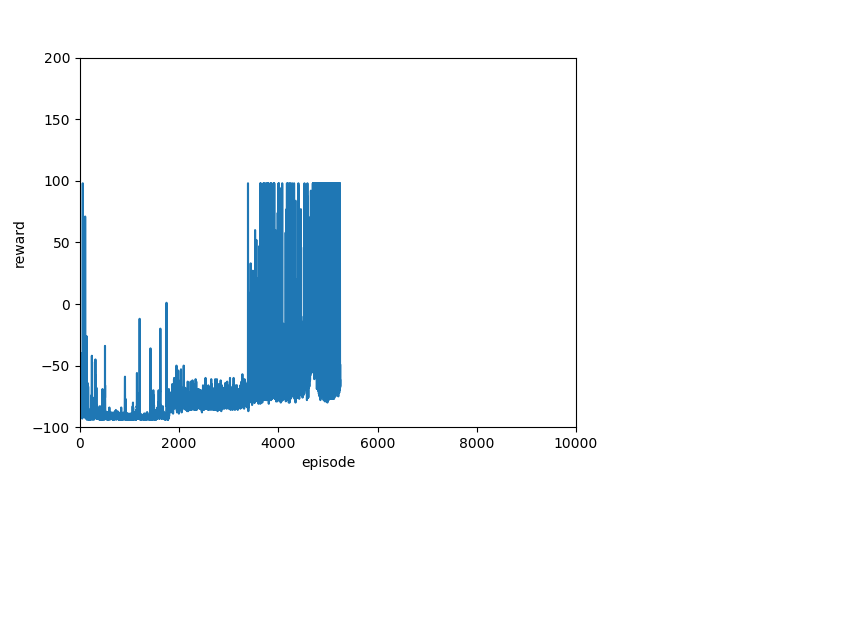

Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

Episode number: 416
Episode number: 417
Episode number: 418
Episode number: 419
Episode number: 420
Episode number: 421
Episode number: 422
Episode number: 423
Episode number: 424
Episode number: 425
Episode number: 426
Episode number: 427
Episode number: 428
Episode number: 429
Episode number: 430
Episode number: 431
Episode number: 432
Episode number: 433
Episode number: 434
Episode number: 435
Episode number: 436
Episode number: 437
Episode number: 438
Episode number: 439
Episode number: 440
Episode number: 441
Episode number: 442
Episode number: 443
Episode number: 444
Episode number: 445
Episode number: 446
Episode number: 447
Episode number: 448
Episode number: 449
Episode number: 450
Episode number: 451
Episode number: 452
Episode number: 453
Episode number: 454
Episode number: 455
Episode number: 456
Episode number: 457
Episode number: 458
Episode number: 459
Episode number: 460
Episode number: 461
Episode number: 462
Episode number: 463
Episode number: 464
Episode number: 465


Episode number: 826
Episode number: 827
Episode number: 828
Episode number: 829
Episode number: 830
Episode number: 831
Episode number: 832
Episode number: 833
Episode number: 834
Episode number: 835
Episode number: 836
Episode number: 837
Episode number: 838
Episode number: 839
Episode number: 840
Episode number: 841
Episode number: 842
Episode number: 843
Episode number: 844
Episode number: 845
Episode number: 846
Episode number: 847
Episode number: 848
Episode number: 849
Episode number: 850
Episode number: 851
Episode number: 852
Episode number: 853
Episode number: 854
Episode number: 855
Episode number: 856
Episode number: 857
Episode number: 858
Episode number: 859
Episode number: 860
Episode number: 861
Episode number: 862
Episode number: 863
Episode number: 864
Episode number: 865
Episode number: 866
Episode number: 867
Episode number: 868
Episode number: 869
Episode number: 870
Episode number: 871
Episode number: 872
Episode number: 873
Episode number: 874
Episode number: 875


Episode number: 1225
Episode number: 1226
Episode number: 1227
Episode number: 1228
Episode number: 1229
Episode number: 1230
Episode number: 1231
Episode number: 1232
Episode number: 1233
Episode number: 1234
Episode number: 1235
Episode number: 1236
Episode number: 1237
Episode number: 1238
Episode number: 1239
Episode number: 1240
Episode number: 1241
Episode number: 1242
Episode number: 1243
Episode number: 1244
Episode number: 1245
Episode number: 1246
Episode number: 1247
Episode number: 1248
Episode number: 1249
Episode number: 1250
Episode number: 1251
Episode number: 1252
Episode number: 1253
Episode number: 1254
Episode number: 1255
Episode number: 1256
Episode number: 1257
Episode number: 1258
Episode number: 1259
Episode number: 1260
Episode number: 1261
Episode number: 1262
Episode number: 1263
Episode number: 1264
Episode number: 1265
Episode number: 1266
Episode number: 1267
Episode number: 1268
Episode number: 1269
Episode number: 1270
Episode number: 1271
Episode numbe

Episode number: 1617
Episode number: 1618
Episode number: 1619
Episode number: 1620
Episode number: 1621
Episode number: 1622
Episode number: 1623
Episode number: 1624
Episode number: 1625
Episode number: 1626
Episode number: 1627
Episode number: 1628
Episode number: 1629
Episode number: 1630
Episode number: 1631
Episode number: 1632
Episode number: 1633
Episode number: 1634
Episode number: 1635
Episode number: 1636
Episode number: 1637
Episode number: 1638
Episode number: 1639
Episode number: 1640
Episode number: 1641
Episode number: 1642
Episode number: 1643
Episode number: 1644
Episode number: 1645
Episode number: 1646
Episode number: 1647
Episode number: 1648
Episode number: 1649
Episode number: 1650
Episode number: 1651
Episode number: 1652
Episode number: 1653
Episode number: 1654
Episode number: 1655
Episode number: 1656
Episode number: 1657
Episode number: 1658
Episode number: 1659
Episode number: 1660
Episode number: 1661
Episode number: 1662
Episode number: 1663
Episode numbe

Episode number: 2009
Episode number: 2010
Episode number: 2011
Episode number: 2012
Episode number: 2013
Episode number: 2014
Episode number: 2015
Episode number: 2016
Episode number: 2017
Episode number: 2018
Episode number: 2019
Episode number: 2020
Episode number: 2021
Episode number: 2022
Episode number: 2023
Episode number: 2024
Episode number: 2025
Episode number: 2026
Episode number: 2027
Episode number: 2028
Episode number: 2029
Episode number: 2030
Episode number: 2031
Episode number: 2032
Episode number: 2033
Episode number: 2034
Episode number: 2035
Episode number: 2036
Episode number: 2037
Episode number: 2038
Episode number: 2039
Episode number: 2040
Episode number: 2041
Episode number: 2042
Episode number: 2043
Episode number: 2044
Episode number: 2045
Episode number: 2046
Episode number: 2047
Episode number: 2048
Episode number: 2049
Episode number: 2050
Episode number: 2051
Episode number: 2052
Episode number: 2053
Episode number: 2054
Episode number: 2055
Episode numbe

Episode number: 2400
Episode number: 2401
Episode number: 2402
Episode number: 2403
Episode number: 2404
Episode number: 2405
Episode number: 2406
Episode number: 2407
Episode number: 2408
Episode number: 2409
Episode number: 2410
Episode number: 2411
Episode number: 2412
Episode number: 2413
Episode number: 2414
Episode number: 2415
Episode number: 2416
Episode number: 2417
Episode number: 2418
Episode number: 2419
Episode number: 2420
Episode number: 2421
Episode number: 2422
Episode number: 2423
Episode number: 2424
Episode number: 2425
Episode number: 2426
Episode number: 2427
Episode number: 2428
Episode number: 2429
Episode number: 2430
Episode number: 2431
Episode number: 2432
Episode number: 2433
Episode number: 2434
Episode number: 2435
Episode number: 2436
Episode number: 2437
Episode number: 2438
Episode number: 2439
Episode number: 2440
Episode number: 2441
Episode number: 2442
Episode number: 2443
Episode number: 2444
Episode number: 2445
Episode number: 2446
Episode numbe

Episode number: 2791
Episode number: 2792
Episode number: 2793
Episode number: 2794
Episode number: 2795
Episode number: 2796
Episode number: 2797
Episode number: 2798
Episode number: 2799
Episode number: 2800
Episode number: 2801
Episode number: 2802
Episode number: 2803
Episode number: 2804
Episode number: 2805
Episode number: 2806
Episode number: 2807
Episode number: 2808
Episode number: 2809
Episode number: 2810
Episode number: 2811
Episode number: 2812
Episode number: 2813
Episode number: 2814
Episode number: 2815
Episode number: 2816
Episode number: 2817
Episode number: 2818
Episode number: 2819
Episode number: 2820
Episode number: 2821
Episode number: 2822
Episode number: 2823
Episode number: 2824
Episode number: 2825
Episode number: 2826
Episode number: 2827
Episode number: 2828
Episode number: 2829
Episode number: 2830
Episode number: 2831
Episode number: 2832
Episode number: 2833
Episode number: 2834
Episode number: 2835
Episode number: 2836
Episode number: 2837
Episode numbe

Episode number: 3182
Episode number: 3183
Episode number: 3184
Episode number: 3185
Episode number: 3186
Episode number: 3187
Episode number: 3188
Episode number: 3189
Episode number: 3190
Episode number: 3191
Episode number: 3192
Episode number: 3193
Episode number: 3194
Episode number: 3195
Episode number: 3196
Episode number: 3197
Episode number: 3198
Episode number: 3199
Episode number: 3200
Episode number: 3201
Episode number: 3202
Episode number: 3203
Episode number: 3204
Episode number: 3205
Episode number: 3206
Episode number: 3207
Episode number: 3208
Episode number: 3209
Episode number: 3210
Episode number: 3211
Episode number: 3212
Episode number: 3213
Episode number: 3214
Episode number: 3215
Episode number: 3216
Episode number: 3217
Episode number: 3218
Episode number: 3219
Episode number: 3220
Episode number: 3221
Episode number: 3222
Episode number: 3223
Episode number: 3224
Episode number: 3225
Episode number: 3226
Episode number: 3227
Episode number: 3228
Episode numbe

Episode number: 3574
Episode number: 3575
Episode number: 3576
Episode number: 3577
Episode number: 3578
Episode number: 3579
Episode number: 3580
Episode number: 3581
Episode number: 3582
Episode number: 3583
Episode number: 3584
Episode number: 3585
Episode number: 3586
Episode number: 3587
Episode number: 3588
Episode number: 3589
Episode number: 3590
Episode number: 3591
Episode number: 3592
Episode number: 3593
Episode number: 3594
Episode number: 3595
Episode number: 3596
Episode number: 3597
Episode number: 3598
Episode number: 3599
Episode number: 3600
Episode number: 3601
Episode number: 3602
Episode number: 3603
Episode number: 3604
Episode number: 3605
Episode number: 3606
Episode number: 3607
Episode number: 3608
Episode number: 3609
Episode number: 3610
Episode number: 3611
Episode number: 3612
Episode number: 3613
Episode number: 3614
Episode number: 3615
Episode number: 3616
Episode number: 3617
Episode number: 3618
Episode number: 3619
Episode number: 3620
Episode numbe

Episode number: 3966
Episode number: 3967
Episode number: 3968
Episode number: 3969
Episode number: 3970
Episode number: 3971
Episode number: 3972
Episode number: 3973
Episode number: 3974
Episode number: 3975
Episode number: 3976
Episode number: 3977
Episode number: 3978
Episode number: 3979
Episode number: 3980
Episode number: 3981
Episode number: 3982
Episode number: 3983
Episode number: 3984
Episode number: 3985
Episode number: 3986
Episode number: 3987
Episode number: 3988
Episode number: 3989
Episode number: 3990
Episode number: 3991
Episode number: 3992
Episode number: 3993
Episode number: 3994
Episode number: 3995
Episode number: 3996
Episode number: 3997
Episode number: 3998
Episode number: 3999
Episode number: 4000
Episode number: 4001
Episode number: 4002
Episode number: 4003
Episode number: 4004
Episode number: 4005
Episode number: 4006
Episode number: 4007
Episode number: 4008
Episode number: 4009
Episode number: 4010
Episode number: 4011
Episode number: 4012
Episode numbe

Episode number: 4358
Episode number: 4359
Episode number: 4360
Episode number: 4361
Episode number: 4362
Episode number: 4363
Episode number: 4364
Episode number: 4365
Episode number: 4366
Episode number: 4367
Episode number: 4368
Episode number: 4369
Episode number: 4370
Episode number: 4371
Episode number: 4372
Episode number: 4373
Episode number: 4374
Episode number: 4375
Episode number: 4376
Episode number: 4377
Episode number: 4378
Episode number: 4379
Episode number: 4380
Episode number: 4381
Episode number: 4382
Episode number: 4383
Episode number: 4384
Episode number: 4385
Episode number: 4386
Episode number: 4387
Episode number: 4388
Episode number: 4389
Episode number: 4390
Episode number: 4391
Episode number: 4392
Episode number: 4393
Episode number: 4394
Episode number: 4395
Episode number: 4396
Episode number: 4397
Episode number: 4398
Episode number: 4399
Episode number: 4400
Episode number: 4401
Episode number: 4402
Episode number: 4403
Episode number: 4404
Episode numbe

Episode number: 4749
Episode number: 4750
Episode number: 4751
Episode number: 4752
Episode number: 4753
Episode number: 4754
Episode number: 4755
Episode number: 4756
Episode number: 4757
Episode number: 4758
Episode number: 4759
Episode number: 4760
Episode number: 4761
Episode number: 4762
Episode number: 4763
Episode number: 4764
Episode number: 4765
Episode number: 4766
Episode number: 4767
Episode number: 4768
Episode number: 4769
Episode number: 4770
Episode number: 4771
Episode number: 4772
Episode number: 4773
Episode number: 4774
Episode number: 4775
Episode number: 4776
Episode number: 4777
Episode number: 4778
Episode number: 4779
Episode number: 4780
Episode number: 4781
Episode number: 4782
Episode number: 4783
Episode number: 4784
Episode number: 4785
Episode number: 4786
Episode number: 4787
Episode number: 4788
Episode number: 4789
Episode number: 4790
Episode number: 4791
Episode number: 4792
Episode number: 4793
Episode number: 4794
Episode number: 4795
Episode numbe

Episode number: 5140
Episode number: 5141
Episode number: 5142
Episode number: 5143
Episode number: 5144
Episode number: 5145
Episode number: 5146
Episode number: 5147
Episode number: 5148
Episode number: 5149
Episode number: 5150
Episode number: 5151
Episode number: 5152
Episode number: 5153
Episode number: 5154
Episode number: 5155
Episode number: 5156
Episode number: 5157
Episode number: 5158
Episode number: 5159
Episode number: 5160
Episode number: 5161
Episode number: 5162
Episode number: 5163
Episode number: 5164
Episode number: 5165
Episode number: 5166
Episode number: 5167
Episode number: 5168
Episode number: 5169
Episode number: 5170
Episode number: 5171
Episode number: 5172
Episode number: 5173
Episode number: 5174
Episode number: 5175
Episode number: 5176
Episode number: 5177
Episode number: 5178
Episode number: 5179
Episode number: 5180
Episode number: 5181
Episode number: 5182
Episode number: 5183
Episode number: 5184
Episode number: 5185
Episode number: 5186
Episode numbe

In [ ]:
buffer_size = 10000
batch_size = 32
gamma = 0.99
max_epsilon = 1
min_epsilon = 0.01
learning_rate = 0.001 
problem = 'CartPole-v0'
agent = Agent()
agent.train(10000)
#try_env(problem)


<IPython.core.display.Javascript object>


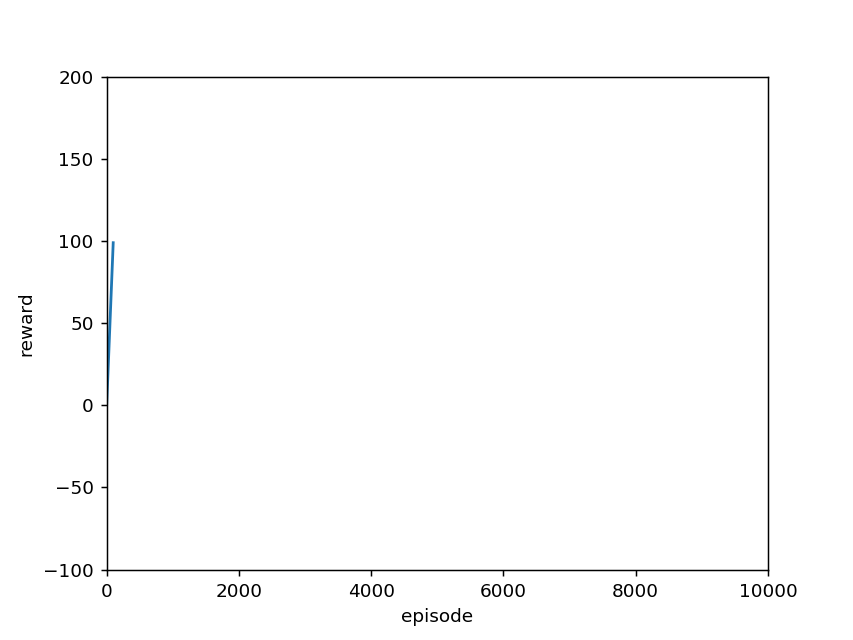

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('episode')
ax.set_ylabel('reward')
ax.set_xlim(0,10000)
ax.set_ylim(-100,200)
plt.ion()

fig.show()
fig.canvas.draw()
history = []
for i in range(0,100):
    history.append(i)
    ax.clear()
    ax.set_xlabel('episode')
    ax.set_ylabel('reward')
    ax.set_xlim(0,10000)
    ax.set_ylim(-100,200)
    ax.plot(history)
    fig.canvas.draw()